In [285]:
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [286]:
def get_windows(job,n_neighbors):
    '''
    For each region and each individual cell in dataset, return the indices of the nearest neighbors.
    
    'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
    n_neighbors:  the number of neighbors to find for each cell
    '''
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

#     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)
#     m = m[0][:,1:], m[1][:,1:]
    m = m[0], m[1]
    

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)

In [298]:
ks = [10] # k=5 means it collects 10 nearest neighbors for each center cell
path_to_data = '/Users/melnike/Desktop/cells_with_ClusterName.csv'
X = 'X'
Y = 'Y'
reg = 'Region'
file_type = 'csv'

cluster_col = 'ClusterName'
keep_cols = [X,Y,reg,cluster_col]
save_path = '/Users/melnike/Desktop'

In [299]:
#read in data and do some quick data rearrangement
n_neighbors = max(ks)
assert (file_type=='csv' or file_type =='pickle') #


if file_type == 'pickle':
    cells = pd.read_pickle(path_to_data)
if file_type == 'csv':
    cells = pd.read_csv(path_to_data)

cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],axis = 1)


#cells = cells.reset_index() #Uncomment this line if you do any subsetting of dataframe such as removing dirt etc or will throw error at end of next next code block (cell 6)

sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

In [300]:
# Print columns to debug
print("Columns in cells DataFrame:", cells.columns)

Columns in cells DataFrame: Index(['CellID', 'DAPI', 'FoxP3', 'CD68', 'aSMA', 'CD31', 'CD38', 'IDO.1',
       's_Parameter', 'CD11c', 'PD.L1', 'Ki.67', 'CD8', 'PD.1', 'CD4', 'CK',
       'CD3', 'CD20', 'CD16', 'HLA.DR', 'Vimentin', 'CD45', 'X', 'Y',
       'cluster', 'ClusterName', 'Region', 'Groups', 'Patient', 'APC T help',
       'B cells', 'CAFs', 'CD31+TAM', 'Endothelial', 'IDO-1+ Tumor APCs',
       'Immune/Cancer cells', 'Inflammatory Monocytes', 'MPs',
       'Proliferating Tumor APCs', 'Proliferative MPs', 'T help', 'TAM',
       'Tcyt', 'Treg', 'Tumor', 'Tumor APCs'],
      dtype='object')


In [301]:
#find windows for each cell in each tissue region
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]

Starting: 1/1 : A
Finishing: 1/1 : A 0.07524609565734863 0.0754549503326416


In [302]:
print("Unique experiments in the dataset:", exps)
print("Tissue chunks:", tissue_chunks)

Unique experiments in the dataset: ['A']
Tissue chunks: [(1701263060.93152, 0, 'A', Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       17589, 17590, 17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598],
      dtype='int64', length=17599))]


In [303]:
#for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)

#concatenate the summed windows and combine into one dataframe for each window size tested.
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],axis =0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],axis =1)
    windows[k] = window

In [304]:
k = 7
n_neighborhoods = 7
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [305]:
windows2 = windows[10]
# windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0, n_init=3)

labelskm = km.fit_predict(windows2[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells['neighborhood7'] = labelskm
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
#['reg064_A','reg066_A','reg018_B','reg023_A']

In [306]:
cell_order = ['Endothelial', 
              'Proliferative MPs', 
              'B cells', 
              'T help', 
              'CAFs', 
              'Tumor', 
              'Tumor APCs', 
              'Inflammatory Monocytes', 
              'TAM', 
              'Tcyt', 
              'APC T help', 
              'CD31+TAM', 
              'IDO-1+ Tumor APCs', 
              'Proliferating Tumor APCs', 
              'Treg', 
              'Immune/Cancer cells']

In [307]:
print("Keys in k_centroids:", k_centroids.keys())
print(fc.index)

Keys in k_centroids: dict_keys([7])
RangeIndex(start=0, stop=5, step=1)


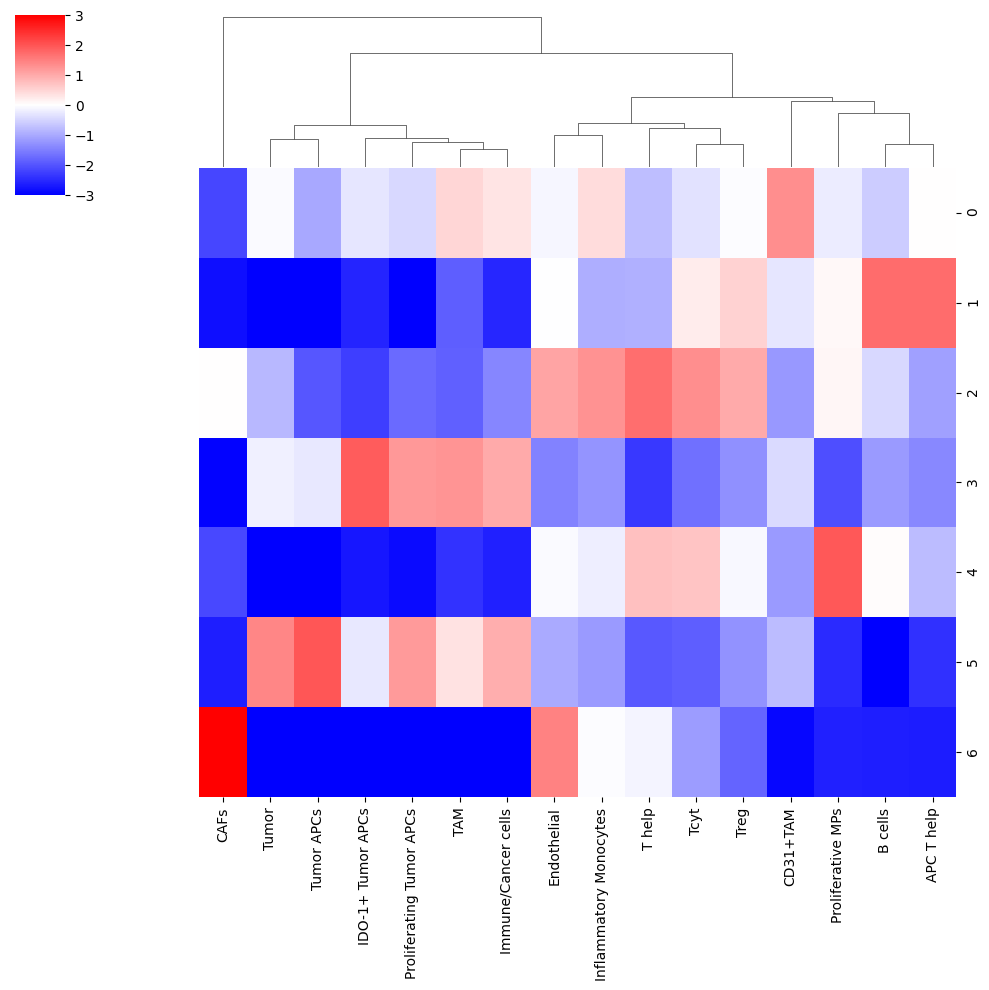

In [309]:
# this plot shows the types of cells (ClusterIDs) in the different niches (0-7)
k_to_plot = 7
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, 
                                                                            keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc.loc[[0,1,2,3,4,5,6],cell_order], 
                 vmin =-3,vmax = 3, 
                 cmap = 'bwr',
                 row_cluster = False)
# s.savefig("raw_figs/celltypes_perniche_10.pdf")

In [310]:
print(cells.columns)

Index(['CellID', 'DAPI', 'FoxP3', 'CD68', 'aSMA', 'CD31', 'CD38', 'IDO.1',
       's_Parameter', 'CD11c', 'PD.L1', 'Ki.67', 'CD8', 'PD.1', 'CD4', 'CK',
       'CD3', 'CD20', 'CD16', 'HLA.DR', 'Vimentin', 'CD45', 'X', 'Y',
       'cluster', 'ClusterName', 'Region', 'Groups', 'Patient', 'APC T help',
       'B cells', 'CAFs', 'CD31+TAM', 'Endothelial', 'IDO-1+ Tumor APCs',
       'Immune/Cancer cells', 'Inflammatory Monocytes', 'MPs',
       'Proliferating Tumor APCs', 'Proliferative MPs', 'T help', 'TAM',
       'Tcyt', 'Treg', 'Tumor', 'Tumor APCs', 'neighborhood7'],
      dtype='object')


<Figure size 1000x800 with 0 Axes>

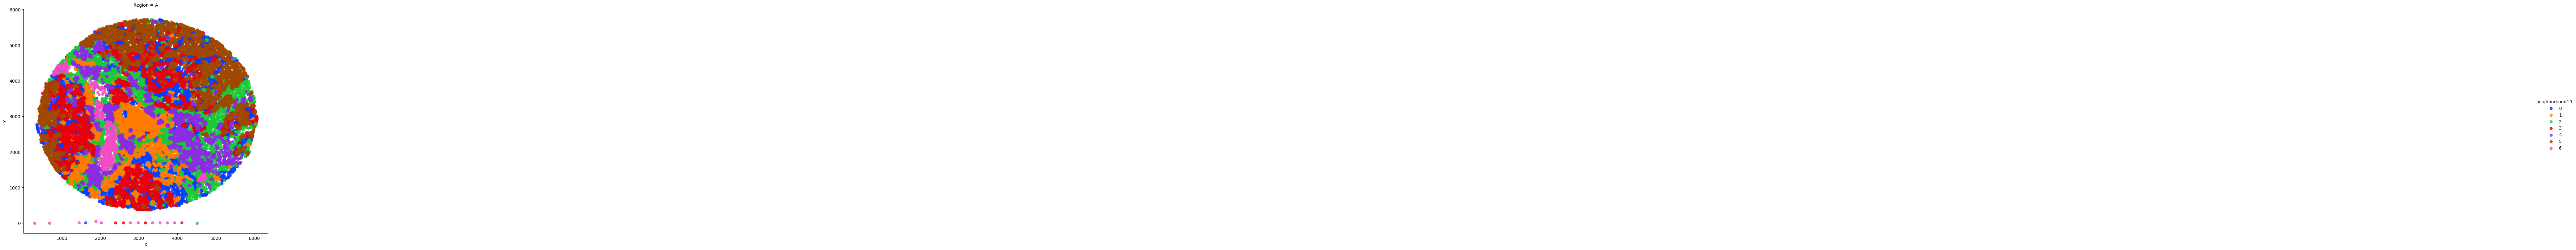

In [312]:
cells['neighborhood10'] = cells['neighborhood7'].astype('category')
# Reverse the order of levels in 'neighborhood10'
# Set the figure size explicitly
plt.figure(figsize=(10, 8))  # Adjust width and height as needed
sns.lmplot(data=cells[cells['Groups'] == 1],
           x='X',
           y='Y',
           hue='neighborhood10',
           palette='bright',
          height=8,  # Adjust the aspect ratio if needed
           col=reg,
           col_wrap=10,
           fit_reg=False)

In [313]:
cells.to_pickle('/Users/melnike/Desktop/cells_with_ClusterName.pkl')

In [314]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from shapely.ops import polygonize,unary_union
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi


        
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    adapted from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647 3.18.2019
    
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def plot_voronoi(points,colors,invert_y = True,edge_color = 'facecolor',line_width = .1,alpha = 1,size_max=np.inf):
    
# spot_samp = spot#.sample#(n=100,random_state = 0)
# points = spot_samp[['X:X','Y:Y']].values
# colors = [sns.color_palette('bright')[i] for i in spot_samp['neighborhood10']]

    if invert_y:
        points[:,1] = max(points[:,1])-points[:,1]
    vor = Voronoi(points)

    regions, vertices = voronoi_finite_polygons_2d(vor)

    pts = MultiPoint([Point(i) for i in points])
    mask = pts.convex_hull
    new_vertices = []
    if type(alpha)!=list:
        alpha = [alpha]*len(points)
    areas = []
    for i,(region,alph) in enumerate(zip(regions,alpha)):
        polygon = vertices[region]
        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
        areas+=[p.area]
        if p.area <size_max:
            poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
            new_vertices.append(poly)
            if edge_color == 'facecolor':
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  colors[i],linewidth = line_width , facecolor = colors[i])
            else:
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  edge_color,linewidth = line_width, facecolor = colors[i])
        # else:

        #     plt.scatter(np.mean(p.boundary.xy[0]),np.mean(p.boundary.xy[1]),c = colors[i])
    return areas
def draw_voronoi_scatter(spot,c,voronoi_palette = sns.color_palette('bright'),
                         scatter_palette = 'voronoi',
                         X = 'X', Y = 'Y',
                         voronoi_hue = 'neighborhood10',
                         scatter_hue = 'ClusterName',
        figsize = (5,5),
         voronoi_kwargs = {},
         scatter_kwargs = {}):
    if scatter_palette=='voronoi':
        scatter_palette = voronoi_palette
        scatter_hue = voronoi_hue
    '''
    plot voronoi of a region and overlay the location of specific cell types onto this
    
    spot:  cells that are used for voronoi diagram
    c:  cells that are plotted over voronoi
    palette:  color palette used for coloring neighborhoods
    X/Y:  column name used for X/Y locations
    hue:  column name used for neighborhood allocation
    figsize:  size of figure
    voronoi_kwargs:  arguments passed to plot_vornoi function
    scatter_kwargs:  arguments passed to plt.scatter()

    returns sizes of each voronoi to make it easier to pick a size_max argument if necessary
    '''
    if len(c)>0:
        neigh_alpha = .3
    else:
        neigh_alpha = 1
        
    voronoi_kwargs = {**{'alpha':neigh_alpha},**voronoi_kwargs}
    scatter_kwargs = {**{'s':50,'alpha':1,'marker':'.'},**scatter_kwargs}
    
    plt.figure(figsize = figsize)
    colors  = [voronoi_palette[i] for i in spot[voronoi_hue]]
    a = plot_voronoi(spot[[X,Y]].values,
                 colors,#[{0:'white',1:'red',2:'purple'}[i] for i in spot['color']],
                 **voronoi_kwargs)
    
    if len(c)>0:
        if 'c' not in scatter_kwargs:
            colors  = [scatter_palette[i] for i in c[scatter_hue]]
            scatter_kwargs['c'] = colors
            
        plt.scatter(x = c[X],y = (max(spot[Y])-c[Y].values),
                  **scatter_kwargs
                   )
    plt.axis('off');
    return a

In [315]:
# Path to your CSV file
csv_file_path = '/Users/melnike/Desktop/cells_with_ClusterName.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

# Path to save the pickle file
pickle_file_path = '/Users/melnike/Desktop/cells_with_ClusterName.pkl'

# Save the DataFrame to a pickle file
df.to_pickle(pickle_file_path)

cells2 = pd.read_pickle('/Users/melnike/Desktop/cells_with_ClusterName.pkl')

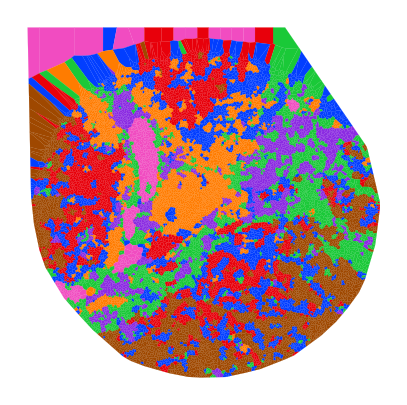

In [316]:
spot = draw_voronoi_scatter(cells,[],)